In [1]:
import networkx as nx
import pickle
import random
import scipy
from scipy.sparse import tril, find
import django
import sys, os
import pandas as pd
import matplotlib.pyplot as plt
import igraph
from django.core.management import call_command

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.tasks import *

from django.db.models import Count, Sum

qid= 6230
q = Query.objects.get(pk=qid)

sample = 0

# You need to call the management command to generate the network, if this is a new query
regenerate_matrix = False
if regenerate_matrix:
    call_command('bib_matrix', qid, 0, "/home/galm/projects/CCU/citation_data")

Cmat = scipy.sparse.load_npz(f'citation_data/bibCouple_q_{qid}_{sample}.npz')

with open(f"citation_data/docnet_dict_q_{qid}_{sample}.pickle", "rb") as f:
    m_dict = pickle.load(f)
with open(f"citation_data/docnet_revdict_q_{qid}_{sample}.pickle", "rb") as f:
    rev_m_dict = pickle.load(f)

Cmat.data *= Cmat.data>=1
Cmat.eliminate_zeros()

Cmat



<1974x1974 sparse matrix of type '<class 'numpy.int64'>'
	with 285004 stored elements in Compressed Sparse Row format>

In [2]:
def check_cites(bc,rev_m_dict, i=0):
    d1 = Doc.objects.get(pk=rev_m_dict[bc[0][i]])
    d2 = Doc.objects.get(pk=rev_m_dict[bc[1][i]])
    print(bc[2][i])
    return set(d2.wosarticle.cr) & set(d1.wosarticle.cr)

bc = find(tril(Cmat,k=-1))

check_cites(bc, rev_m_dict, 11)


3


{'Arab P, 2014, CHEM MATER, V26, P1385, DOI 10.1021/cm403161e',
 'Rabbani MG, 2012, CHEM COMMUN, V48, P1141, DOI 10.1039/c2cc16986j',
 'Suresh VM, 2014, ACS APPL MATER INTER, V6, P4630, DOI 10.1021/am500057z'}

In [3]:
## TODO read graph better, use find, get edge weights and 
def read_network(Cmat, rev_m_dict, doc_ids=None):
    g = igraph.Graph()
    g.add_vertices(len(rev_m_dict))
    edges = []
    weights = []
    n1s, n2s, ews = find(tril(Cmat,k=-1))
    for i, n1 in enumerate(n1s):
        if doc_ids:
            if rev_m_dict[n1] not in doc_ids or rev_m_dict[n2s[i]] not in doc_ids:
                continue
        e = (n1,n2s[i])
        edges.append(e)
        weights.append(ews[i])
    g.add_edges(edges)
    g.es["weight"] = weights

    g.vs["doc_id"] = list(rev_m_dict.values())
    return g
    pass

g = read_network(Cmat, rev_m_dict)
print(g.summary())

IGRAPH U-W- 1974 141515 -- 
+ attr: doc_id (v), weight (e)


In [4]:
g = g.clusters().giant()

In [5]:
from fa2 import ForceAtlas2

forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,  # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=1,

    # Performance
    jitterTolerance=1.0,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,  # NOT IMPLEMENTED

    # Tuning
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=1,

    # Log
    verbose=True
)

positions = forceatlas2.forceatlas2_igraph_layout(g, pos=None, iterations=2000, weight_attr="weight")

100%|██████████| 2000/2000 [00:50<00:00, 39.37it/s]

BarnesHut Approximation  took  17.37  seconds
Repulsion forces  took  22.98  seconds
Gravitational forces  took  0.19  seconds
Attraction forces  took  7.25  seconds
AdjustSpeedAndApplyForces step  took  1.06  seconds


In [6]:
clusters = g.community_fastgreedy(weights="weight")
cl = clusters.as_clustering()


In [8]:
def summarise_cluster(cl, rev_m_dict, qs, c_threshold):
    ids = [g.vs[x]["doc_id"] for x in cl]
    docs = Doc.objects.filter(
        pk__in=ids,
        query__in=qs
    ).values('query__title').annotate(
        n=Count('pk')
    ).order_by('-n')
    df = pd.DataFrame.from_dict(list(docs))
    df['pc'] = round(df['n'] / df['n'].sum(),2)
    t = "\n".join([f"{r['query__title']} - {r['pc']:.0%}" for i,r in df.iterrows() if r['pc']>c_threshold])
    return t
                   
def summarise_category_cluster(cl, project, c_threshold):
    ids = [g.vs[x]["doc_id"] for x in cl]               
    dos = DocOwnership.objects.filter(
        doc__id__in=ids,
        query__project=project,
        relevant=1
    ).values('query__category__name').annotate(
        n = Count('pk')
    ).order_by('-n')
    df = pd.DataFrame.from_dict(list(dos))
    df['pc'] = round(df['n'] / df['n'].sum(),2)
    t = "\n".join([f"{r['query__category__name']} - {r['pc']:.0%}" for i,r in df.iterrows() if r['pc']>c_threshold])
    return t

def summarise_topic_cluster(cl, rev_m_dict, run_id, c_threshold):
    ids = [g.vs[x]["doc_id"] for x in cl]
    docs = Doc.objects.filter(
        pk__in=ids,
        doctopic__run_id=run_id
    ).values('doctopic__topic__title').annotate(
        n=Sum('doctopic__score')
    ).order_by('-n')
    df = pd.DataFrame.from_dict(list(docs))
    df['pc'] = round(df['n'] / df['n'].sum(),2)
    t = "\n".join([f"{r['doctopic__topic__title']} - {r['pc']:.0%}" for i,r in df.iterrows() if r['pc']>c_threshold])
    return t

def draw_network(ax, g, layout, labels, 
                 interactive=False, clusters=None, 
                 qs=None, min_c_size=0,
                 v_padding=50,
                 c_threshold=0.1, run_id=None,
                 rev_m_dict=None, pos="top",
                 category_sum=False,project=None
                ):
    #label_ids = [l['id'] for l in labels]
    ax.grid(False)
    ax.axis('off')
    
    x_offset=0
    if clusters:
        if rev_m_dict:
            pass
            
        for c in clusters:
            x = [x[0] for i,x in enumerate(layout) if i in c]
            y = [x[1] for i,x in enumerate(layout) if i in c] 
            scatter = ax.scatter(x,y,edgecolor="black")
            
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        xrange = xlim[1] - xlim[0]
        yrange = ylim[1] - ylim[0]
        x_step = xrange/3
        if pos=="top":
            ha = "center"
            x_offset = x_step/2
        else:
            ha="left"
            x_offset = xrange
        y_offset = 0
        texts = []
        for i,c in enumerate(clusters):
            x = [x[0] for i,x in enumerate(layout) if i in c]
            y = [x[1] for i,x in enumerate(layout) if i in c] 
            scatter = ax.scatter(x,y,edgecolor="black")
            if len(c) < min_c_size:
                continue
            col = scatter.get_facecolors()[0]
            if qs:
                t = summarise_cluster(c,rev_m_dict,qs,c_threshold)
            elif run_id:
                t = summarise_topic_cluster(c,rev_m_dict,run_id,c_threshold)
            elif category_sum:
                t = summarise_category_cluster(c, project, c_threshold)
            else:
                t = ""
            t = f"Cluster {i} - {len(c)} docs\n\n{t}"
            text = ax.text(
                    xlim[0]+x_offset,
                    ylim[1]+y_offset,
                    t,
                    bbox={'facecolor':col, 'alpha':0.5, 'pad':0.4, 'boxstyle': 'round'},
                    va="top",
                    ha=ha
                )
            texts.append(text)
            if pos=="top":
                x_offset+=x_step
                if xlim[0]+x_offset > xlim[1]:
                    fig.canvas.draw()
                    bs = []
                    for t in texts:
                        box = t.get_bbox_patch().get_window_extent()
                        tcbox = ax.transData.inverted().transform(box)
                        bs.append(tcbox[0][1])

                    y_offset+=min(bs)-ylim[1]
                    x_offset = x_step/2
            else:
                fig.canvas.draw()
                box = text.get_bbox_patch().get_window_extent()
                tcbox = ax.transData.inverted().transform(box)
                b = tcbox[0][1]

                y_offset=b-ylim[1] - v_padding           
            
            
            #ax.text(cx, cy, "ASDFASDFASFD")
    else:
        x = [x[0] for x in layout]
        y = [x[1] for x in layout]
        scatter = ax.scatter(x,y,edgecolor="black")


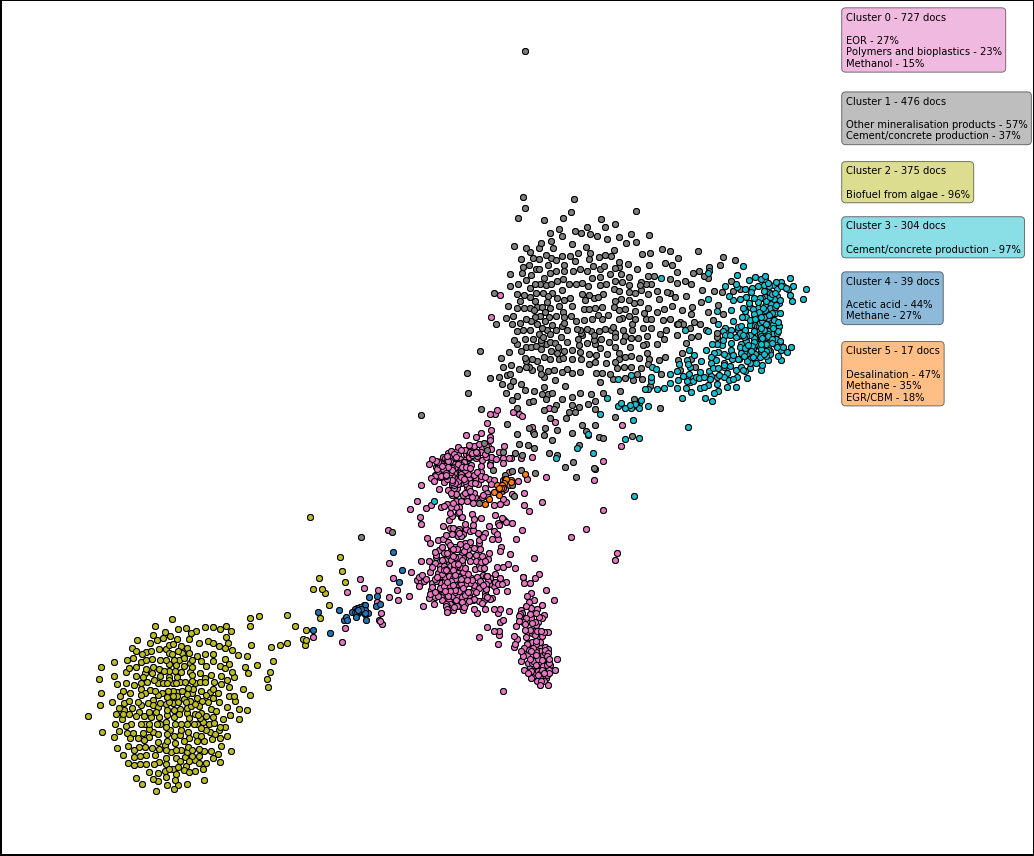

In [9]:
   
fig, ax = plt.subplots(figsize=(12,12),edgecolor="black",frameon=True,linewidth=4)

draw_network(
    ax, g, positions, [], clusters=cl,
    category_sum=True, rev_m_dict=rev_m_dict,
    pos="right",project=q.project
)
#draw_network(ax, g, positions, [])

fig.tight_layout()

plt.savefig(f"plots/citation_networks/bibgraph_couple_forceatlas_fastgreedy_{qid}.svg")
plt.savefig(
    f"plots/citation_networks/bibgraph_couple_forceatlas_fastgreedy_{qid}.png",
    bbox_inches="tight"
)

plt.show()



In [10]:
# Set this to the last year we want to include
max_year = 2014
min_year = 2007

# We can filter when we read in the network, if we only want to see an early part of the graph
docs = Doc.objects.filter(pk__in=list(rev_m_dict.values())).filter(PY__lte=max_year,PY__gte=min_year)
doc_ids = docs.values_list('pk',flat=True)
print(docs.count())

g = read_network(Cmat, rev_m_dict, doc_ids)
g = g.clusters().giant()
print(g.summary())

# Workout layout
forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,  # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=1,

    # Performance
    jitterTolerance=1.0,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,  # NOT IMPLEMENTED

    # Tuning
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=1,

    # Log
    verbose=True
)

positions = forceatlas2.forceatlas2_igraph_layout(g, pos=None, iterations=2000, weight_attr="weight")

clusters = g.community_fastgreedy(weights="weight")
cl = clusters.as_clustering()

612
IGRAPH U-W- 588 18423 -- 
+ attr: doc_id (v), weight (e)


100%|██████████| 2000/2000 [00:10<00:00, 190.90it/s]


BarnesHut Approximation  took  2.95  seconds
Repulsion forces  took  5.64  seconds
Gravitational forces  took  0.06  seconds
Attraction forces  took  0.92  seconds
AdjustSpeedAndApplyForces step  took  0.33  seconds


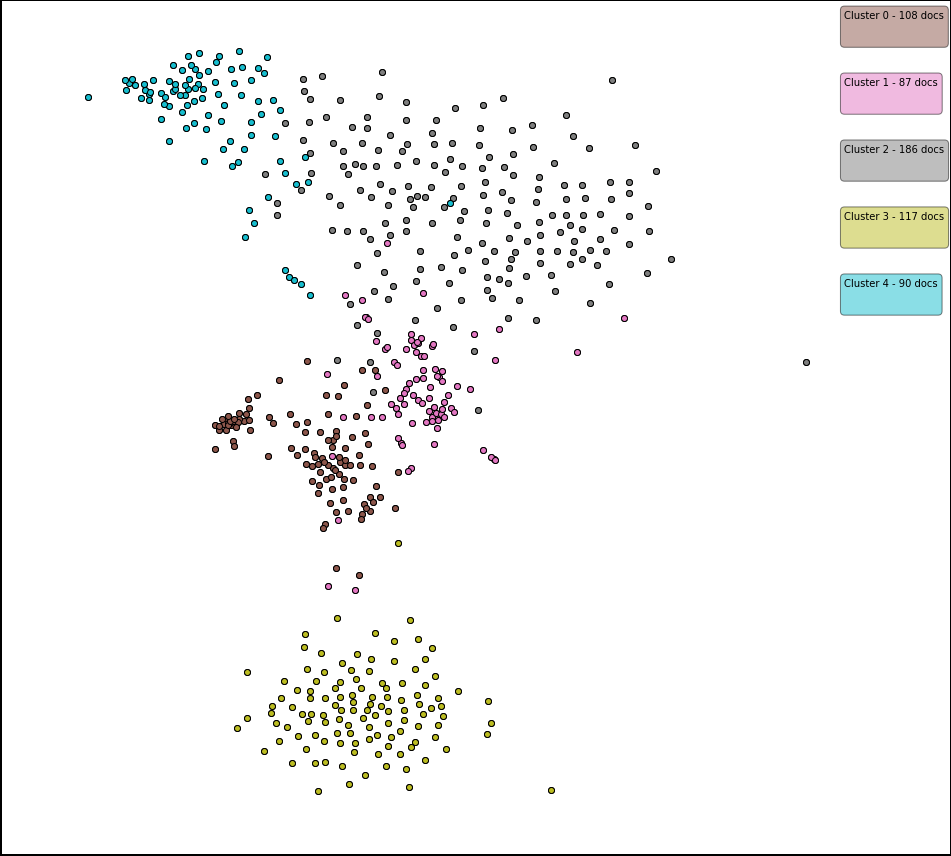

In [11]:
fig, ax = plt.subplots(figsize=(12,12),edgecolor="black",frameon=True,linewidth=4)

draw_network(
    ax, g, positions, [], clusters=cl, 
    rev_m_dict=rev_m_dict,pos="right",
    category_sum=True
)
#draw_network(ax, g, positions, [])

fig.tight_layout()

plt.savefig(f"plots/citation_networks/bibgraph_couple_forceatlas_fastgreedy_{qid}_{max_year}.svg")
plt.savefig(
    f"plots/citation_networks/bibgraph_couple_forceatlas_fastgreedy_{qid}_{max_year}.png",
    bbox_inches="tight"
)

plt.show()
